In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ipywidgets import interact, widgets

from helper.plotting_settings import FULLSIZE, PARTSIZE, set_labels


In [2]:
# Interactive plots when using vscode
%matplotlib widget

In [3]:
df_massless = pd.read_csv("..\\results\\MegAWES_massless_analytical.csv", dtype=float)
df_massless_star = pd.read_csv(
    "..\\results\\MegAWES_massless_analytical_star.csv", dtype=float
)
df_mass = pd.read_csv("..\\results\\MegAWES_cleaned.csv", dtype=float)
df_mass_star = pd.read_csv("..\\results\\MegAWES_star.csv")

In [4]:
# Add the course angle to the massless case so we can index them in the same way as the
# DataFrame with mass.
df_massless["chi_deg"] = 90
df_massless_star["chi_deg"] = 90

In [5]:
def set_sliders(with_mass=False):
    sliders = {
        "vw_mps": widgets.SelectionSlider(
            options=np.unique(np.linspace(2.5, 30, 12)),
            value=30.0,
            description="wind speed [m/s]",
            disabled=False,
            continuous_update=True,
            orientation="horizontal",
            readout=True,
        ),
        "beta_deg": widgets.SelectionSlider(
            options=[0.0, 30.0],
            value=0.0,
            description="elevation [deg]",
            disabled=False,
            continuous_update=False,
            orientation="horizontal",
            readout=True,
        ),
        "phi_deg": widgets.SelectionSlider(
            options=[0.0, 17.5],
            value=0.0,
            description="azimuth [deg]",
            disabled=False,
            continuous_update=False,
            orientation="horizontal",
            readout=True,
        ),
        "Lt_m": widgets.SelectionSlider(
            options=[500.0, 1000.0, 1500.0],
            value=1000,
            description="tether length [m]",
            disabled=False,
            continuous_update=False,
            orientation="horizontal",
            readout=True,
        ),
        "chi_deg": widgets.SelectionSlider(
            options=np.unique(np.linspace(0, 180, 5, dtype=int)),
            value=90.0,
            description="course angle [deg]",
            disabled=False,
            continuous_update=False,
            orientation="horizontal",
            readout=True,
        ),
        "with_mass": widgets.SelectionSlider(
            options=[False, True],
            value=with_mass,
            description="with mass",
            disabled=False,
            continuous_update=False,
            orientation="horizontal",
            readout=True,
        ),
    }
    return sliders

In [6]:
for df in [df_mass, df_massless, df_mass_star, df_massless_star]:
    df['sum_angles'] = df['beta_deg'] + df['phi_deg']

In [7]:
# Make a color map. We want a different color for each possible combination of beta and
# phi. Their sum happens to be unique.
sum_angles = df_mass['beta_deg'] + df_mass['phi_deg']
colors = sns.color_palette(n_colors=len(sum_angles.unique()))
sum_betaphi_to_color = dict(zip(sum_angles.unique(), colors))
len(sum_betaphi_to_color)

chis = [0, 90, 180]
color = sns.color_palette(n_colors=len(chis))
chi_to_color = dict(zip(chis, color))


interactive(children=(SelectionSlider(description='wind speed [m/s]', index=11, options=(2.5, 5.0, 7.5, 10.0, …

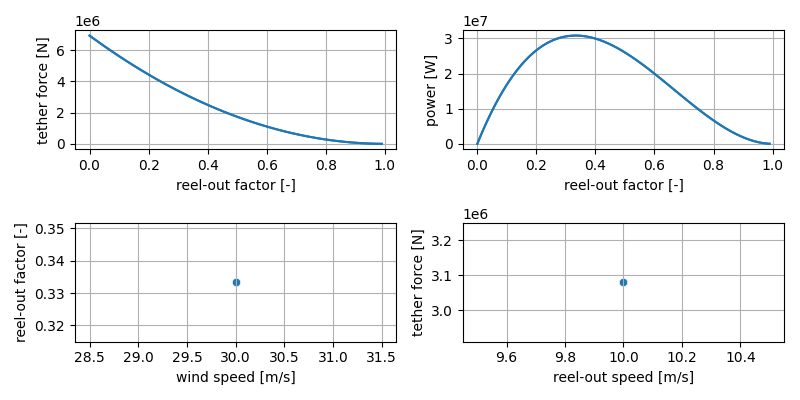

In [8]:
plt.close()
fig, axs = plt.subplots(2, 2, figsize=(8, 4))


def vrFtP_and_vrFt_plot(
    vw_mps,
    beta_deg,
    phi_deg,
    Lt_m,
    chi_deg,
    with_mass,
):

    df = df_mass if with_mass else df_massless
    df_star = df_mass_star if with_mass else df_massless_star

    f_min = -0.01 if with_mass else 0.0

    temp = df[
        (df["vw_mps"] == vw_mps)
        & (df["beta_deg"] == beta_deg)
        & (df["phi_deg"] == phi_deg)
        & (df["Lt_m"] == Lt_m)
        & (df["chi_deg"] == chi_deg)
        & (df["f"] >= f_min)
    ]

    temp_star = df_star[
        (df_star["vw_mps"] == vw_mps)
        & (df_star["beta_deg"] == beta_deg)
        & (df_star["phi_deg"] == phi_deg)
        & (df_star["Lt_m"] == Lt_m)
        & (df_star["chi_deg"] == chi_deg)
    ]

    color = sum_betaphi_to_color[beta_deg + phi_deg]

    # Plot tether force and power output as function of reelout factor. Here we can see
    # that there's a certain optimum.
    for ax, y in zip(axs[0, :], ["Ftg_N", "P_W"]):
        sns.lineplot(
            data=temp,
            x="f",
            y=y,
            ax=ax,
            legend=False,
            color=color,
        )

    # In the second row we only plot the ideal part of the curve.
    # Once ideal reelout factor per wind speed and the winch control curve (v_r, Ft).
    sns.scatterplot(
        data=temp_star,
        x="vw_mps",
        y="f_star",
        ax=axs[1, 0],
        legend=False,
        color=color,
    )
    sns.scatterplot(
        data=temp_star,
        x="vr_mps_star",
        y="Ftg_N_star",
        ax=axs[1, 1],
        legend=False,
        color=color,
    )


# Plot once to initialise the plot and set labels and the layout.
tic = time.time()
vrFtP_and_vrFt_plot(30.0, 0.0, 0.0, 1000.0, 90.0, False)
toc = time.time()
# print(toc-tic)
set_labels(axs)
plt.tight_layout()
for ax_h in axs:
    for ax in ax_h:
        ax.grid()

# Make the interactive plot.
sliders = set_sliders(False)
_ = interact(vrFtP_and_vrFt_plot, **sliders)


interactive(children=(SelectionSlider(description='wind speed [m/s]', index=11, options=(2.5, 5.0, 7.5, 10.0, …

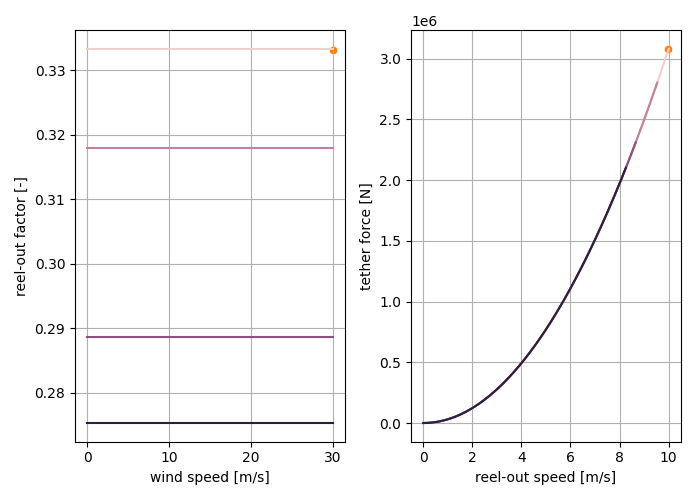

In [14]:
plt.close()
fig, axs = plt.subplots(1, 2, figsize=(7, 5))

# Plot optimum for massless kites at a certain tether length.
temp = df_massless_star[df_massless_star['Lt_m'] == 1000]
sns.lineplot(data=temp, x='vw_mps', y='f_star', hue='sum_angles', ax=axs[0], legend=False)
sns.lineplot(data=temp, x='vr_mps_star', y='Ftg_N_star', hue='sum_angles', ax=axs[1], legend=False)


def vrFtP_and_vrFt_plot(
    vw_mps,
    beta_deg,
    phi_deg,
    Lt_m,
    chi_deg,
    with_mass,
):

    df = df_mass if with_mass else df_massless
    df_star = df_mass_star if with_mass else df_massless_star

    f_min = -0.01 if with_mass else 0.0

    temp = df[
        (df["vw_mps"] == vw_mps)
        & (df["beta_deg"] == beta_deg)
        & (df["phi_deg"] == phi_deg)
        & (df["Lt_m"] == Lt_m)
        & (df["chi_deg"] == chi_deg)
        & (df["f"] >= f_min)
    ]

    temp_star = df_star[
        (df_star["vw_mps"] == vw_mps)
        & (df_star["beta_deg"] == beta_deg)
        & (df_star["phi_deg"] == phi_deg)
        & (df_star["Lt_m"] == Lt_m)
        & (df_star["chi_deg"] == chi_deg)
    ]

    color = chi_to_color[chi_deg]

    # # Plot tether force and power output as function of reelout factor. Here we can see
    # # that there's a certain optimum.
    # for ax, y in zip(axs[0, :], ["Ftg_N", "P_W"]):
    #     sns.lineplot(
    #         data=temp,
    #         x="f",
    #         y=y,
    #         ax=ax,
    #         legend=False,
    #         color=color,
    #     )

    # In the second row we only plot the ideal part of the curve.
    # Once ideal reelout factor per wind speed and the winch control curve (v_r, Ft).
    sns.scatterplot(
        data=temp_star,
        x="vw_mps",
        y="f_star",
        ax=axs[0],
        legend=False,
        color=color,
    )
    sns.scatterplot(
        data=temp_star,
        x="vr_mps_star",
        y="Ftg_N_star",
        ax=axs[1],
        legend=False,
        color=color,
    )


# Plot once to initialise the plot and set labels and the layout.
tic = time.time()
vrFtP_and_vrFt_plot(30.0, 0.0, 0.0, 1000.0, 90.0, True)
toc = time.time()
# print(toc-tic)
set_labels(axs)
plt.tight_layout()
for ax in axs:
    ax.grid()

# Make the interactive plot.
sliders = set_sliders(True)
_ = interact(vrFtP_and_vrFt_plot, **sliders)
